In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications import VGG16, vgg16

In [2]:
from matplotlib import gridspec

## GPU Setup

In [3]:
# Check availability of GPU
import nvidia_smi 

GPU = 1
os.environ["CUDA_VISIBLE_DEVICES"] = '{}'.format(GPU)

gpus = tf.config.experimental.list_physical_devices('GPU')
print('GPU is', 'available' if gpus else 'NOT AVAILABLE')
print('Number GPUs Available: ', len(gpus))


# Restrict TensorFlow to only use the MENTIONED GPU
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print('{} Physical GPUs, Logical GPU'.format(len(gpus), len(logical_gpus)))
        print('Memory growth set to: {} '.format(str(tf.config.experimental.get_memory_growth(gpus[0]))))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

GPU is available
Number GPUs Available:  1
1 Physical GPUs, Logical GPU
Memory growth set to: True 


2022-03-21 19:41:54.048858: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-21 19:41:54.769994: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30452 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:65:00.0, compute capability: 8.6


In [4]:
# Initiate NVIDIA-SMI
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(GPU)

In [5]:
import os
from matplotlib.image import imread
import numpy as np


class PreProcessing:

    images_train = np.array([])
    images_test = np.array([])
    labels_train = np.array([])
    labels_test = np.array([])
    unique_train_label = np.array([])
    map_train_label_indices = dict()

    def __init__(self,data_src):
        self.data_src = data_src
        print("Loading Geological Similarity Dataset...")
        self.images_train, self.images_test, self.labels_train, self.labels_test = self.preprocessing(0.9)
        self.unique_train_label = np.unique(self.labels_train)
        self.map_train_label_indices = {label: np.flatnonzero(self.labels_train == label) for label in
                                        self.unique_train_label}
        print('Preprocessing Done. Summary:')
        print("Images train :", self.images_train.shape)
        print("Labels train :", self.labels_train.shape)
        print("Images test  :", self.images_test.shape)
        print("Labels test  :", self.labels_test.shape)
        print("Unique label :", self.unique_train_label)

    def normalize(self,x):
        min_val = np.min(x)
        max_val = np.max(x)
        x = (x - min_val) / (max_val - min_val)
        return x

    def read_dataset(self):
        X = []
        y = []
        for directory in os.listdir(self.data_src):
            try:
                for pic in os.listdir(os.path.join(self.data_src, directory)):
                    img = imread(os.path.join(self.data_src, directory, pic))
                    X.append(np.squeeze(np.asarray(img)))
                    y.append(directory)
            except Exception as e:
                print('Failed to read images from Directory: ', directory)
                print('Exception Message: ', e)
        print('Dataset loaded successfully.')
        return X,y

    def preprocessing(self,train_test_ratio):
        X, y = self.read_dataset()
        labels = list(set(y))
        label_dict = dict(zip(labels, range(len(labels))))
        Y = np.asarray([label_dict[label] for label in y])
        X = [self.normalize(x) for x in X]                                  # normalize images

        shuffle_indices = np.random.permutation(np.arange(len(y)))
        x_shuffled = []
        y_shuffled = []
        for index in shuffle_indices:
            x_shuffled.append(X[index])
            y_shuffled.append(Y[index])

        size_of_dataset = len(x_shuffled)
        n_train = int(np.ceil(size_of_dataset * train_test_ratio))
        return np.asarray(x_shuffled[0:n_train]), np.asarray(x_shuffled[n_train + 1:size_of_dataset]), np.asarray(
            y_shuffled[0:n_train]), np.asarray(y_shuffled[
                                               n_train + 1:size_of_dataset])


    def get_triplets(self):
        label_l, label_r = np.random.choice(self.unique_train_label, 2, replace=False)
        a, p = np.random.choice(self.map_train_label_indices[label_l],2, replace=False)
        n = np.random.choice(self.map_train_label_indices[label_r])
        return a, p, n

    def get_triplets_batch(self):
        idxs_a, idxs_p, idxs_n = [], [], []
        n = len(self.labels_train)
        for _ in range(n):
            a, p, n = self.get_triplets()
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)
            
        anchor_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_a,:])
        positive_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_p,:])
        negative_dataset = tf.data.Dataset.from_tensor_slices(self.images_train[idxs_n, :])

        dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
        
        return dataset

In [6]:
class TripletLoss:
    
    def embedding(self):
        inp = Input(shape=(28,28,3))
        
        # first block
        c1 = Conv2D(32, (7,7), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(inp)
        m1 = MaxPooling2D((2,2), padding='same')(c1)

        # second block
        c2 = Conv2D(64, (5,5), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m1)
        m2 = MaxPooling2D((2,2), padding='same')(c2)

        # third block
        c3 = Conv2D(128, (3,3), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m2)
        m3 = MaxPooling2D((2,2), padding='same')(c3)
        
        # fourth block
        c4 = Conv2D(256, (1,1), activation='relu', padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m3)
        m4 = MaxPooling2D((2,2), padding='same')(c4)

        c5 = Conv2D(28, (1,1), activation=None, padding='same', kernel_initializer=tf.keras.initializers.GlorotNormal())(m4)
        m5 = MaxPooling2D((2,2), padding='same')(c5)


        f1 = Flatten()(m5)
        
        return Model(inputs=[inp], outputs=[f1], name='embedding')

In [7]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [8]:
dataset = PreProcessing('./sample2/data_repository/geological_similarity/')

Loading Geological Similarity Dataset...
Dataset loaded successfully.
Preprocessing Done. Summary:
Images train : (26999, 28, 28, 3)
Labels train : (26999,)
Images test  : (2998, 28, 28, 3)
Labels test  : (2998,)
Unique label : [0 1 2 3 4 5]


In [9]:
model = TripletLoss()

In [10]:
# placeholder_shape = [None] + list(dataset.images_train.shape[1:])
target_shape = (28,28)

In [11]:
# Setup Network
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

In [12]:
embedding = model.embedding()

In [13]:
distances = DistanceLayer()(
    embedding(anchor_input),
    embedding(positive_input),
    embedding(negative_input),
)

In [14]:
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [15]:
data = dataset.get_triplets_batch()

In [16]:
count = len(dataset.labels_train)

In [17]:
train_dataset = data.take(round(count * 0.8))
val_dataset = data.skip(round(count * 0.8))

In [18]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [19]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):

        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # List metrics here so the `reset_states()` can be called automatically.
        return [self.loss_tracker]

In [20]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001), metrics=['accuracy'])
siamese_model.fit(train_dataset, epochs=40, validation_data=val_dataset)

Epoch 1/40


2022-03-21 19:42:25.270545: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


675/675 [==============================] - 10s 10ms/step - loss: 0.1208 - val_loss: 0.0796
Epoch 2/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0684 - val_loss: 0.0576
Epoch 3/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0573 - val_loss: 0.0612
Epoch 4/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0516 - val_loss: 0.0519
Epoch 5/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0467 - val_loss: 0.0516
Epoch 6/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0423 - val_loss: 0.0415
Epoch 7/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0392 - val_loss: 0.0440
Epoch 8/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0365 - val_loss: 0.0502
Epoch 9/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0338 - val_loss: 0.0486
Epoch 10/40
675/675 [==============================] - 7s 10ms/step - loss: 0.0312 - val_loss: 0.0498

In [45]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])

2022-03-21 19:59:50.970701: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


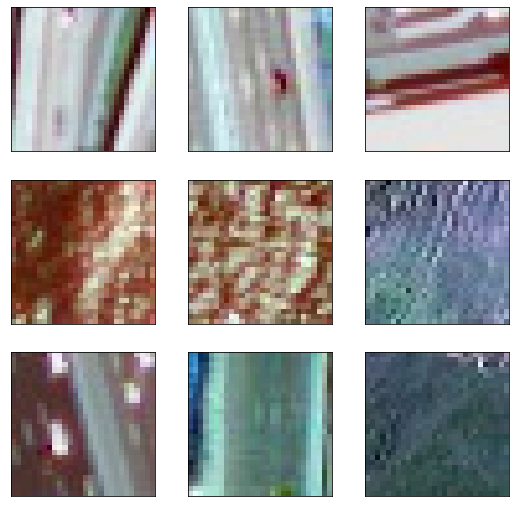

In [46]:
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(anchor),
    embedding(positive),
    embedding(negative),
)

In [47]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Positive similarity:", positive_similarity.numpy())
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.93475497
Negative similarity 0.7960668


In [37]:
def find_k_nn(normalized_train_vectors,vec,k):
    dist_arr = np.matmul(normalized_train_vectors, vec.T)
    return np.argsort(-dist_arr.flatten())[:k]

In [38]:
train_vectors = embedding.predict(train_dataset)

In [39]:
# unit vectors = vectors / norm
normalized_train_vectors = train_vectors/np.linalg.norm(train_vectors,axis=1).reshape(-1,1)

In [36]:
im_iter = next(iter(train_dataset))
images = [tf.data.Dataset.from_tensor_slices(im_i) for im_i in im_iter]
# images = [im_i.numpy() for im_i in im_iter]

In [37]:
# im_batch = [tf.expand_dims(im, axis=0) for im in images]
im_batch = [im.batch(1, drop_remainder=False) for im in images]

In [42]:
im_batch

[<BatchDataset shapes: (None, 28, 28, 3), types: tf.float64>,
 <BatchDataset shapes: (None, 28, 28, 3), types: tf.float64>,
 <BatchDataset shapes: (None, 28, 28, 3), types: tf.float64>]

In [43]:
sample = tf.data.Dataset.zip((im_batch[0], im_batch[1], im_batch[2]))

In [44]:
search_vector = embedding.predict(sample)

In [136]:
normalized_search_vec = search_vector/np.linalg.norm(search_vector)

In [140]:
k = 10
candidate_index = find_k_nn(normalized_train_vectors, normalized_search_vec, k)

In [141]:
def show_image(idxs, data):
    if type(idxs) != np.ndarray:
        idxs = np.array([idxs])
    fig = plt.figure()
    gs = gridspec.GridSpec(1,len(idxs))
    for i in range(len(idxs)):
        ax = fig.add_subplot(gs[0,i])
        ax.imshow(data[idxs[i],:,:,:])
        ax.axis('off')
    plt.show()

NameError: name 'idxs' is not defined

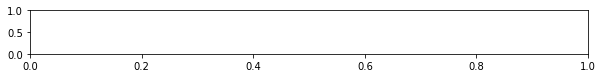

In [148]:
fig = plt.figure(figsize=(10, 0.8))
gs = gridspec.GridSpec(1, 1)
for i in range(1):
    ax = fig.add_subplot(gs[0, i])
    ax.imshow(test_images[idxs[i], :, :, :])
    ax.axis('off')
plt.show()
show_image(candidate_index, train_images)